<a href="https://colab.research.google.com/github/zhou100/FoodSecurityPrediction/blob/master/Predict_FS_MW_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use machine learning to predict food security

In [1]:
# Set up Notebook
% matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

 ## Read in the data cleaned out by R

If you are using google colab like me, you will need to mount your google drive first and  copy the cleaned dataset from the R project to your google drive. 

If you are using python/jupyter notebook locally, just point to the right directory. 

In [2]:
! ls data/clean/dataset

mw_dataset_cluster.csv tz_dataset_cluster.csv ug_dataset_cluster.csv
mw_dataset_hh.csv      tz_dataset_hh.csv      ug_dataset_hh.csv


In [3]:
mw_clust= pd.read_csv("data/clean/dataset/mw_dataset_cluster.csv")

## Preprocessing data


### One-hot encoding for string variables 

In [4]:
mw_clust["FNID"]= mw_clust["FNID"].str.lstrip('MW2012C')
fnid_mw_clust = pd.get_dummies(mw_clust["FNID"],prefix='MW', drop_first=True)
mw_clust = pd.concat([mw_clust, fnid_mw_clust], axis=1)

In [289]:
mw_clust.head()

,FS_year,FNID,FCS,HDDS,rCSI,region_north,region_central,rural,dist_road,dist_admarc,...,MW_3030716,MW_3030804,MW_3030816,MW_3030904,MW_3031005,MW_3031105,MW_3031206,MW_3031213,MW_3031313,MW_3999918
0,2010,3010102,42.718750,5.375000,2.750000,1.0,0.0,1.000000,2.656875,12.016250,...,0,0,0,0,0,0,0,0,0,0
1,2013,3010102,41.500000,4.687500,11.625000,1.0,0.0,1.000000,2.250000,12.687500,...,0,0,0,0,0,0,0,0,0,0
2,2010,3010102,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,...,0,0,0,0,0,0,0,0,0,0
3,2010,3010508,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,...,0,0,0,0,0,0,0,0,0,0
4,2013,3010102,48.088235,5.058824,2.411765,1.0,0.0,0.941176,0.529412,11.411765,...,0,0,0,0,0,0,0,0,0,0


# Methodology


This section will explain our main approach with the data.

1. Focus on categorical prediciton for the given cutoffs. 

Reasons: Close to the actual policy scenarios where we focus on capturing all the insecure households. Recall rate of the insecure villages is more important than the over all accuracy. 

Can apply the down sampling and over sampling technique here to improve 


2.  Algorithms to try : tree classifier, random forest classifier, xgboost 

2.1. By categories, vs one or rest

2.2.  Parameter Tuning

2.3 . feature importance analysis


3.  Error analysis by region, by group, by month

4.  Train model by division separtely Auto-segmentation by training a shallow tree in each country based on observables 

5. Model combination: what happens when we train on all the data 

6. Model generalization issues: what happens when we directly apply  models trained on one country to predict another 







## Exploratory Data Analysis  

### Measures:  plot target measures by year by country


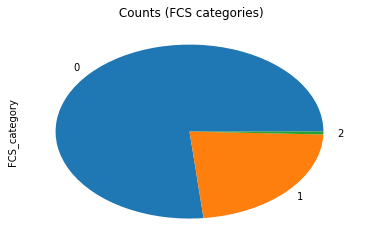

In [5]:
# cut the outcome variables by the cutoffs
mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
  
mw_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')


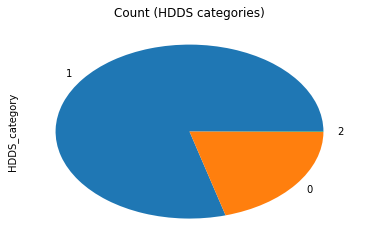

In [6]:
 # HDDS 3 and 6
mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
  
mw_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')


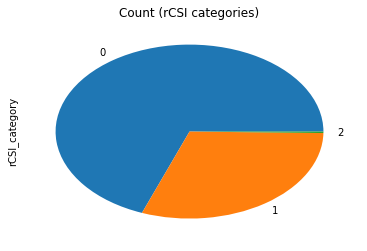

In [7]:
# rCSI 4 and 17  and 42
mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])
  
mw_clust['rCSI_category'].value_counts().plot(kind='pie', title='Count (rCSI categories)')


### Split train and test data

 For practical prediction purposes,  we use the most recent round of survey data  as the testing  and the rest as the training data. 


In [8]:
mw_clust_test_cond =  mw_clust['FS_year']>2015
mw_clust_train_cond =  mw_clust['FS_year']<2016
mw_clust_test = mw_clust[mw_clust_test_cond]
mw_clust_train = mw_clust[mw_clust_train_cond]



**Separate the target/labels from the X variables. **

In [9]:
labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']


mw_clust_y_train= mw_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test= mw_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_test= mw_clust_test.drop(labels+category_labels+['FNID'],  axis=1)
mw_clust_X_train= mw_clust_train.drop(labels+category_labels+['FNID'], axis=1)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

def TreeCLF(X_train,y_train,X_test, y_test):
    # Define tree classifier
    tree_clf = DecisionTreeClassifier(random_state=66)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    # n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=rs, n_jobs = -1)


    tree_random.fit( X_train, y_train)


    # Return accuracy
    tree_test_score = round(tree_random.score(X_test, y_test), 3)
    tree_train_score = round(tree_random.score(X_train, y_train), 3)
    
    return tree_test_score

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


def rfCLF(X_train,y_train,X_test, y_test):

    rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 100,min_samples_split=10,warm_start=True)

        
    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=rs, n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)

    # Return accuracy
    rf_test_score = round(rf_random.score(X_test, y_test), 3)
    rf_train_score = round(rf_random.score(X_train, y_train), 3)

    return rf_test_score 

In [12]:
from xgboost import XGBClassifier

def XGBCLF(X_train,y_train,X_test, y_test):

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=rs, n_jobs = -1)


    
    # Fit the random search model
    XGB_random.fit(X_train, y_train)

    # Return accuracy
    xgb_test_score = round(XGB_random.score(X_test, y_test), 3)
    xgb_train_score = round(XGB_random.score(X_train, y_train), 3)
    
    return xgb_test_score

ModuleNotFoundError: No module named 'xgboost'

In [267]:
mw_clust_y_train['FCS_category'].value_counts()

0    1699
1     461
2      14
Name: FCS_category, dtype: int64

In [312]:
TreeCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.0s
[CV] ..................... max_features=8, max_depth=20, total=   0.0s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.0s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.1s
[CV] max_features=10, max_depth=3 ....................................
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=10, max_depth=3, total=   0.0s
[CV] max_feature

[CV] max_features=18, max_depth=12 ...................................
[CV] max_features=20, max_depth=10 ...................................
[CV] max_features=20, max_depth=10 ...................................
[CV] .................... max_features=18, max_depth=12, total=   0.1s
[CV] max_features=18, max_depth=12 ...................................
[CV] .................... max_features=18, max_depth=12, total=   0.0s
[CV] .................... max_features=20, max_depth=10, total=   0.0s
[CV] .................... max_features=20, max_depth=10, total=   0.0s
[CV] max_features=12, max_depth=18 ...................................
[CV] max_features=12, max_depth=18 ...................................
[CV] .................... max_features=18, max_depth=12, total=   0.0s
[CV] max_features=20, max_depth=10 ...................................
[CV] .................... max_features=12, max_depth=18, total=   0.0s
[CV] .................... max_features=12, max_depth=18, total=   0.0s
[CV] m

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.2s


[CV] .................... max_features=16, max_depth=18, total=   0.0s
[CV] max_features=12, max_depth=4 ....................................
[CV] .................... max_features=12, max_depth=18, total=   0.0s
[CV] .................... max_features=16, max_depth=18, total=   0.0s
[CV] .................... max_features=10, max_depth=20, total=   0.1s
[CV] max_features=12, max_depth=4 ....................................
[CV] max_features=8, max_depth=3 .....................................
[CV] max_features=10, max_depth=4 ....................................
[CV] ..................... max_features=12, max_depth=4, total=   0.0s
[CV] max_features=8, max_depth=3 .....................................
[CV] ..................... max_features=10, max_depth=4, total=   0.0s
[CV] ..................... max_features=12, max_depth=4, total=   0.1s
[CV] max_features=10, max_depth=4 ....................................
[CV] max_features=12, max_depth=4 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.7s finished


0.70099999999999996

In [313]:
TreeCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.0s
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.0s
[CV] ..................... max_features=18, max_depth=3, total=   0.1s
[CV] max_features=8, max_depth=20 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=8, max_depth=20, total=   0.0s
[CV] ..................... max_features=8, max_depth=20, total=   0.0s
[CV] ..................... max_features=8, max_depth=20, total=   0.1s
[CV] max_features=10, max_depth=3 ....................................
[CV] max_feature

[CV] max_features=18, max_depth=12 ...................................
[CV] ..................... max_features=3, max_depth=18, total=   0.1s
[CV] max_features=20, max_depth=10 ...................................
[CV] max_features=20, max_depth=10 ...................................
[CV] .................... max_features=18, max_depth=12, total=   0.0s
[CV] max_features=18, max_depth=12 ...................................
[CV] max_features=12, max_depth=18 ...................................
[CV] .................... max_features=20, max_depth=10, total=   0.0s
[CV] max_features=12, max_depth=18 ...................................
[CV] .................... max_features=12, max_depth=18, total=   0.0s
[CV] max_features=12, max_depth=18 ...................................
[CV] .................... max_features=18, max_depth=12, total=   0.0s
[CV] max_features=10, max_depth=20 ...................................
[CV] .................... max_features=20, max_depth=10, total=   0.1s
[CV] m

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.2s


[CV] max_features=10, max_depth=20 ...................................
[CV] .................... max_features=20, max_depth=10, total=   0.0s
[CV] .................... max_features=10, max_depth=20, total=   0.0s
[CV] max_features=16, max_depth=18 ...................................
[CV] max_features=12, max_depth=4 ....................................
[CV] .................... max_features=10, max_depth=20, total=   0.0s
[CV] .................... max_features=16, max_depth=18, total=   0.0s
[CV] max_features=16, max_depth=18 ...................................
[CV] .................... max_features=16, max_depth=18, total=   0.0s
[CV] max_features=12, max_depth=4 ....................................
[CV] ..................... max_features=12, max_depth=4, total=   0.0s
[CV] .................... max_features=16, max_depth=18, total=   0.0s
[CV] ..................... max_features=12, max_depth=4, total=   0.0s
[CV] max_features=8, max_depth=3 .....................................
[CV] m

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.7s finished


0.64700000000000002

In [314]:
TreeCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.0s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.1s
[CV] ..................... max_features=8, max_depth=20, total=   0.0s
[CV] ..................... max_features=18, max_depth=3, total=   0.1s
[CV] max_features=8, max_depth=20 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=10, max_depth=3, total=   0.0s
[CV] max_features=10, max_depth=3 ....................................
[CV] max_feature

[CV] max_features=12, max_depth=18 ...................................
[CV] ..................... max_features=18, max_depth=8, total=   0.0s
[CV] .................... max_features=20, max_depth=10, total=   0.0s
[CV] max_features=20, max_depth=10 ...................................
[CV] max_features=10, max_depth=20 ...................................
[CV] .................... max_features=10, max_depth=20, total=   0.0s
[CV] max_features=16, max_depth=18 ...................................
[CV] .................... max_features=12, max_depth=18, total=   0.1s
[CV] .................... max_features=18, max_depth=12, total=   0.0s
[CV] max_features=12, max_depth=18 ...................................
[CV] max_features=18, max_depth=12 ...................................
[CV] .................... max_features=20, max_depth=10, total=   0.1s
[CV] max_features=20, max_depth=10 ...................................
[CV] .................... max_features=16, max_depth=18, total=   0.1s
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


0.38

In [319]:
rfCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.7s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.8s
[CV] ..................... max_features=18, max_depth=3, total=   0.8s
[CV] max_features=8, max_depth=20 ....................................
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=8, max_depth=20, total=   1.0s
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=10, max_depth=3, total=   0.7s
[CV] max_feature

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.8s


[CV] ..................... max_features=18, max_depth=4, total=   0.9s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.0s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.0s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.0s
[CV] max_features=14, max_depth=14 ...................................
[CV] ..................... max_features=20, max_depth=6, total=   1.2s
[CV] max_features=14, max_depth=14 ...................................
[CV] ..................... max_features=20, max_depth=6, total=   1.3s
[CV] max_features=14, max_depth=14 ...................................
[CV] ..................... max_features=20, max_depth=6, total=   1.3s
[CV] max_features=3, max_depth=12 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.5s finished


0.69399999999999995

In [320]:
rfCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.9s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.9s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.9s
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=8, max_depth=20, total=   1.2s
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=10, max_depth=3, total=   0.8s
[CV] max_feature

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.2s


[CV] ..................... max_features=18, max_depth=4, total=   0.9s
[CV] max_features=14, max_depth=6 ....................................
[CV] ..................... max_features=18, max_depth=4, total=   0.9s
[CV] max_features=14, max_depth=6 ....................................
[CV] ..................... max_features=18, max_depth=4, total=   1.0s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.2s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.2s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.2s
[CV] max_features=14, max_depth=14 ...................................
[CV] ..................... max_features=20, max_depth=6, total=   1.2s
[CV] max_features=14, max_depth=14 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.6s finished


0.72799999999999998

In [321]:
rfCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=18, max_depth=3 ....................................
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.9s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.9s
[CV] max_features=8, max_depth=20 ....................................
[CV] ..................... max_features=18, max_depth=3, total=   0.9s
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=8, max_depth=20, total=   1.1s
[CV] max_features=10, max_depth=3 ....................................
[CV] ..................... max_features=10, max_depth=3, total=   0.7s
[CV] max_feature

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s


[CV] ..................... max_features=18, max_depth=4, total=   1.0s
[CV] max_features=14, max_depth=6 ....................................
[CV] ..................... max_features=18, max_depth=4, total=   1.1s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.2s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.1s
[CV] max_features=20, max_depth=6 ....................................
[CV] ..................... max_features=14, max_depth=6, total=   1.1s
[CV] max_features=14, max_depth=14 ...................................
[CV] ..................... max_features=20, max_depth=6, total=   1.2s
[CV] max_features=14, max_depth=14 ...................................
[CV] ..................... max_features=20, max_depth=6, total=   1.2s
[CV] max_features=14, max_depth=14 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.4s finished


0.35299999999999998

In [0]:
from xgboost import XGBClassifier
# fit model to  training data
XGB_clf = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.3,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      #objective='binary:logistic', 
                      objective='multi:softmax', 
                      num_class=14,
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=14, 
                      gamma=10)

# Fit the random search model
XGB_clf.fit(X_train, y_train)

# Return accuracy
xgb_test_score = round(XGB_clf.score(X_test, y_test), 3)
xgb_train_score = round(XGB_clf.score(X_train, y_train), 3)
print(xgb_test_score)

### downsample / oversample 

Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Resampling
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.



In [0]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');


In [0]:
import imblearn


For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

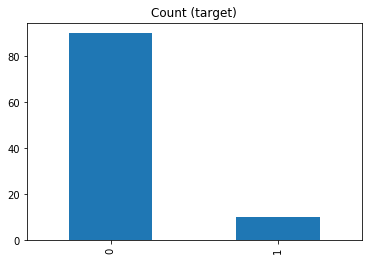

In [0]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');


In [0]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [0]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [0]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

Under-sampling: Tomek links
Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


In [0]:
# confusion matrix , focus on improving the recall rate of the insecure class



In [0]:
# One vs all and plot the AUC ( )

### Models

#### Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

def fit_linear(X_train, X_test,y_train,y_test):

    # Create and fit our linear regression model to training data
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Compute model predictions for test data
    pred = model.predict(X_test)

    r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2

# implement the algorithm and present results
result_table(function=fit_linear)

NameError: ignored

#### Ridge

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV


def fit_ridge(X_train, X_test,y_train,y_test):

  model = RidgeCV(alphas=[0.0, 1E-6, 1E-4, 1E-2, 1.0], fit_intercept=True, normalize=True, scoring=None, cv=5, gcv_mode='auto', store_cv_values=False) 

# Define different alpha values for different fits
# alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

  model.fit(X_train, y_train)

  # Compute model predictions for test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2



# implement the algorithm and present results
result_table(function=fit_ridge)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.265,0.270,0.110
1,Malawi_cluster,0.431,0.642,0.217
2,Tanzania_household,0.048,0.006,0.015
3,Tanzania_cluster,0.153,0.020,0.087
4,Uganda_household,0.179,0.219,0.000
5,Uganda_cluster,0.365,0.421,0.000


In [0]:
from sklearn.linear_model import LassoCV

def fit_lasso(X_train, X_test,y_train,y_test):

    model = LassoCV(eps=0.001, n_alphas=100, alphas=(0.01, 2), fit_intercept=True,precompute='auto',n_jobs=4, random_state=0, selection='cyclic')

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    return r2

  
# implement the algorithm and present results
result_table(function=fit_lasso)

NameError: ignored

In [0]:
from sklearn.linear_model import ElasticNetCV

def fit_en(X_train, X_test,y_train,y_test):


    model = ElasticNetCV(alphas=(0.1,0.02,3,2), copy_X=True, cv=10, eps=0.004, fit_intercept=True,
           l1_ratio=0.33, max_iter=1000, n_alphas=100, n_jobs=1,
           normalize=False, positive=False, precompute='auto', random_state=0,
           selection='cyclic', tol=0.0001, verbose=0)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2


# implement the algorithm and present results
result_table(function=fit_en)    
    

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.377,0.259,0.094
1,Malawi_cluster,0.683,0.587,0.192
2,Tanzania_household,0.048,0.005,0.015
3,Tanzania_cluster,0.153,0.020,0.088
4,Uganda_household,0.141,0.219,0.000
5,Uganda_cluster,0.264,0.387,0.000


In [0]:
from sklearn.ensemble import RandomForestRegressor

def fit_rfc(X_train, X_test,y_train,y_test):
  # Create Regressor with default properties
  rfc = RandomForestRegressor(random_state =0,n_jobs =4,warm_start = True,max_depth=4, min_samples_leaf=5 )
  
  
  parameters = {'max_depth':np.arange( 1,4, 1 ).tolist(), 'min_samples_leaf':np.arange( 1, 4, 1 ).tolist()}
  model = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')

  model.fit(X_train,y_train)
  # Fit estimator and display score

  # Regress on test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2

result_table(function=fit_rfc)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.369,0.269,0.115
1,Malawi_cluster,0.713,0.706,0.267
2,Tanzania_household,0.195,0.221,0.048
3,Tanzania_cluster,0.289,0.385,0.127
4,Uganda_household,0.172,0.189,0.000
5,Uganda_cluster,0.314,0.435,0.000


In [0]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor with default properties
gbr = GradientBoostingRegressor(random_state=0,learning_rate=0.4, n_estimators=9,subsample=1, criterion='friedman_mse', min_samples_split=2)

gbr.fit(x_train, y_train_new)
pred = gbr.predict(x_test)

actual =y_test_new
r2_gbr= stats.pearsonr(actual, pred)[0] ** 2
r2_gbr

In [0]:
from sklearn.gaussian_process import  GaussianProcessRegressor

# Import our kernels
from sklearn.gaussian_process.kernels import Matern, WhiteKernel



# Define custom kernel (Matern + noise)
krnl = 2. + Matern(length_scale=1, nu=1.8) + WhiteKernel(noise_level=10)

# Create Regressor with specified properties
gpr = GaussianProcessRegressor(kernel=krnl, random_state=23)

# Fit estimator and display score
gpr= gpr.fit(x_train, y_train[labels[0]])
pred = gpr.predict(x_test)
actual = y_test[labels[0]]
r2_gpr= stats.pearsonr(actual, pred)[0] ** 2
r2_gpr

pd = {'svc__C': st.uniform(0, 250),
      'svc__gamma': g_vals}
 
# Run randomized search
rscv = RandomizedSearchCV(svp, param_distributions=pd,
                          n_iter=num_samples)

## Visualization

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter( actual_linear,pred_linear)
axs[0, 0].plot(actual_linear,actual_linear, color='red')

axs[1, 0].scatter( actual_rfr, pred_rfr)
axs[1, 0].plot(actual_rfr, actual_rfr, color='red')


axs[0, 1].scatter(actual_en ,pred_en )
axs[0, 1].plot(actual_en,actual_en, color='red')

axs[1, 1].scatter(actual_gbr, pred_gbr )
axs[1, 1].plot(actual_gbr, actual_gbr, color='red')


axs[0, 0].title.set_text('Scatter Plot Linear')
axs[1, 0].title.set_text('Scatter Plot RandomForest')
axs[0, 1].title.set_text('Scatter Plot ElasticNet')
axs[1, 1].title.set_text('Scatter Plot GradientBoosting')
plt.show()

## Interpretation


Hit and misses 

expand the prediction to grid level 